# Object Tracking

In this assignment, you will implement the **SORT** model, using a pretrained object detection network. If you are unfamiliar with the algorithm, you can read [the original paper](https://arxiv.org/abs/1602.00763). It's a really good read.

![Object Tracking.jpg](https://www.researchgate.net/profile/Laura-Leal-Taixe/publication/268987905/figure/fig1/AS:654775909629952@1533122150189/Tracking-by-detection-paradigm-Firstly-an-independent-detector-is-applied-to-all_W640.jpg)



## Setup

In [1]:
%%capture 
!apt-get install tree

In [2]:
%%capture
!pip install filterpy

In [3]:
from pathlib import Path

In [4]:
import os

In [5]:
import cv2 

In [6]:
from google.colab.patches import cv2_imshow

In [7]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches 

In [9]:
from tqdm.auto import tqdm 

In [10]:
from filterpy.kalman import KalmanFilter

## SORT

The task is pretty straightforward. You will begin by downloading a benchmark dataset. Considering that we aren't actually going to train a neural network, we don't need to go through the complicated process of defining a `tf.data.Dataset` subclass. After that, you will have to set up a pretrained object detector and define the association algorithm. Finally, you will apply the tracking algorithm to the benchmark dataset and evaluate the performance using a Python dataset.

### Preparing the Data

[**MOT15**](https://motchallenge.net/data/MOT15/) is a rather small and widely popular multi-object tracking dataset that we can use. In this datasets, humans have been annotated with a series of bounding boxes. Each series is associated with a single entity and is own as its **track**. 

We can download the dataset directly from the link below.

In [11]:
!wget https://motchallenge.net/data/MOT15.zip

--2023-01-16 17:23:18--  https://motchallenge.net/data/MOT15.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310994213 (1.2G) [application/zip]
Saving to: ‘MOT15.zip’

MOT15.zip           100%[===================>]   1.22G  10.3MB/s    in 2m 5s   

2023-01-16 17:25:23 (10.0 MB/s) - ‘MOT15.zip’ saved [1310994213/1310994213]



If we then decompress this archive, 

In [12]:
!unzip -qq MOT15.zip

we will get the following folder structure:

In [13]:
!tree -d -L 3 MOT15 

MOT15
├── test
│   ├── ADL-Rundle-1
│   │   ├── det
│   │   └── img1
│   ├── ADL-Rundle-3
│   │   ├── det
│   │   └── img1
│   ├── AVG-TownCentre
│   │   ├── det
│   │   └── img1
│   ├── ETH-Crossing
│   │   ├── det
│   │   └── img1
│   ├── ETH-Jelmoli
│   │   ├── det
│   │   └── img1
│   ├── ETH-Linthescher
│   │   ├── det
│   │   └── img1
│   ├── KITTI-16
│   │   ├── det
│   │   └── img1
│   ├── KITTI-19
│   │   ├── det
│   │   └── img1
│   ├── PETS09-S2L2
│   │   ├── det
│   │   └── img1
│   ├── TUD-Crossing
│   │   ├── det
│   │   └── img1
│   └── Venice-1
│       ├── det
│       └── img1
└── train
    ├── ADL-Rundle-6
    │   ├── det
    │   ├── gt
    │   └── img1
    ├── ADL-Rundle-8
    │   ├── det
    │   ├── gt
    │   └── img1
    ├── ETH-Bahnhof
    │   ├── det
    │   ├── gt
    │   └── img1
    ├── ETH-Pedcross2
    │   ├── det
    │   ├── gt
    │   └── img1
    ├── ETH-Sunnyday
    │   ├── det
    │   ├── gt
    │   └── img1
    ├── KITTI-13
    │   ├── det
    │   ├── 

The dataset has been split into two subsets, `train` and `test`. Within each subset, we have several videos, each with its own separate directory. Each directory contains the ground truth annotations as a text file within a subdirectory named `gt`, and the extracted frames from the video saved as JPEG images within the `img1` subdirectory. There is also a set of public detections stored as `det` which we won't use.

In [14]:
data_dir = Path('MOT15')

### Object Detector

In order to simplify the process, we will use the `cv2.dnn` module, which can easily load and run the YOLOv7 model. This is one of the most recently released versions of YOLO, which has exceeded the previous models in both accuracy and speed quite signifcantly. Luckily for us, the model is already trained to detect humans, our target entities within the MOT15 dataset.

First, we will need to download the weights and the configuration file for the model. They can be both found [here](https://github.com/AlexeyAB/darknet).

In [15]:
!wget -q https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov7.weights 

In [16]:
!wget -q https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov7.cfg

Next, we will load the network using the `cv2.dnn` module. Check out [this tutorial](https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html) to learn how.

In [17]:
##################################
net = cv2.dnn.readNetFromDarknet('yolov7.cfg', 'yolov7.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
##################################

After that, we need to define a `cv2.dnn_DetectionModel` instance by passing the loaded network.

In [18]:
model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(640, 480), scale=1 / 255, swapRB=True)

Finally, let's load a sample image from the dataset and see what the model can find within the image.

In [19]:
im = cv2.imread('MOT15/train/ETH-Sunnyday/img1/000100.jpg')

Note that we need to specify the minimum confidence threshold and the NMS overlapping threshold when using the model. We suggest the following values, but feel free to tune them.

In [20]:
CONFIDENCE_THRESHOLD = 0.2
NMS_THRESHOLD = 0.4 

Finally, we can read the image and pass it to our model:

In [21]:
classes, scores, boxes = model.detect(im, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)

Since are only interested in the humans, we can filter out the rest of the detections. YOLOv7 is trained on the [COCO](https://cocodataset.org/) dataset, and therefore, `person` detections are identified with `classid=0`.

In [22]:
detections = [(box, score) for classid, score, box in zip(classes, scores, boxes) if classid == 0]

Finally, we can visualize the results with a handy utility function:

In [23]:
def visualize(frame, detections):
    frame = frame.copy()
    for (x_min, y_min, w, h), score in detections:
        label = f"{score:.3f}"
        x_max, y_max = x_min + w, y_min + h
        color = (245, 245, 245)
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 1)
        cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_PLAIN, 1, color, 1)
    cv2_imshow(frame)

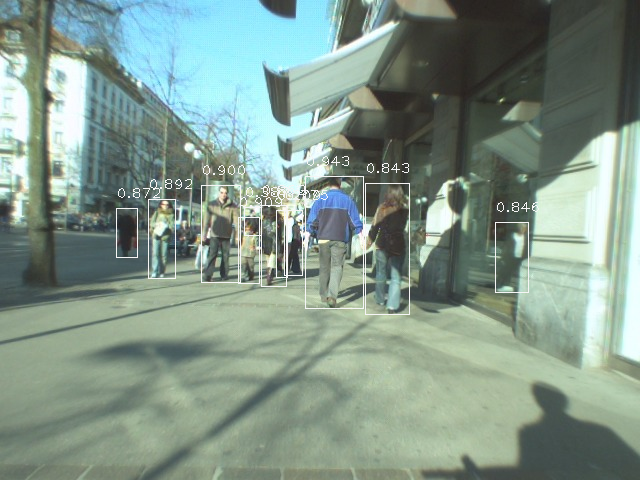

In [24]:
visualize(im, detections)

That's just fantastic!

### Motion Model

Next, we need to define to set up the Kalman filter. Check out [this article](https://www.intechopen.com/chapters/63164) if you'd like to learn more about this filtering algorithm. Furthermore, if you'd like to gain an intuitive understanding of its application in object tracking, this [interesting post](https://towardsdatascience.com/what-i-was-missing-while-using-the-kalman-filter-for-object-tracking-8e4c29f6b795) can be helpful.

We can use the [FilterPy](https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html) package to implement our filter.

In most implementations, the measurement vector of the filtering algorithm ($z$) consists of:

*   Coordinates of the center of the box.
*   The surface area of the box.
*   Width to height ratio of the box.

Therefore, we set `dim_z=4`. On the other hand, the state vector has three extra elements:

*   The velocity of the center coordinates.
*   The rate of change of the surface area.

Meaning that `dim_x=7`. This is, of course, assuming that the aspect ratio of the bounding box doesn't change. 

In [25]:
dim_z = 4
dim_x = 7

Clearly, we need to use an *pseudo*-identity matrix as the measurement function ($H$) of the filter:

In [26]:
H = [
    [1, 0, 0, 0, 0, 0, 0],  # Center X
    [0, 1, 0, 0, 0, 0, 0],  # Center Y
    [0, 0, 1, 0, 0, 0, 0],  # Surface Area
    [0, 0, 0, 1, 0, 0, 0],  # Aspect Ratio
]

The state transition function is a bit tricky, though. Recall the basic formula for position in non-accelerating motion from high school:

$$
x_t = v \cdot \Delta t + x_{t-1}
$$

If we simply assume that `Δt=1` unit of time, we can define state transition matrix as shown below:

In [27]:
F = [
    [1, 0, 0, 0, 1, 0, 0],  # Center X
    [0, 1, 0, 0, 0, 1, 0],  # Center Y
    [0, 0, 1, 0, 0, 0, 1],  # Surface Area
    [0, 0, 0, 1, 0, 0, 0],  # Aspect Ratio
    [0, 0, 0, 0, 1, 0, 0],  # Center X Velocity
    [0, 0, 0, 0, 0, 1, 0],  # Center Y Velocity
    [0, 0, 0, 0, 0, 0, 1],  # Rate of Change of the Aspect Ratio
]

Next, let's define the covariance matrix for the filter. Assuming that our variables are independant of one another (they are not), we only need to define a diagonal matrix as $P$. We can simply go with `1` for the measured attributes and a large number, e.g., `1000` for the ones that have to be calculated. These values will simply be initialized as zero at the start of a track.

In [28]:
P = [
    [1, 0, 0, 0,    0,    0,    0],
    [0, 1, 0, 0,    0,    0,    0],
    [0, 0, 1, 0,    0,    0,    0],
    [0, 0, 0, 1,    0,    0,    0],
    [0, 0, 0, 0, 1000,    0,    0],
    [0, 0, 0, 0,    0, 1000,    0],
    [0, 0, 0, 0,    0,    0, 1000]
]

Note that this matrix will get updated with every observation.

As for $Q$, since the last three elements of the state variable are not directly measured, but rather, calculated, we can express a lower level of uncertainty for their values.


In [29]:
Q = [
    [1, 0, 0, 0,    0,    0,     0],
    [0, 1, 0, 0,    0,    0,     0],
    [0, 0, 1, 0,    0,    0,     0],
    [0, 0, 0, 1,    0,    0,     0],
    [0, 0, 0, 0, 0.01,    0,     0],
    [0, 0, 0, 0,    0, 0.01,     0],
    [0, 0, 0, 0,    0,    0, 0.001],
]

Finally, let's define the measurement uncertainty matrix, $R$. For this one, we cab assume a low value for the directly measured values and a higher value for those that come from some sort of calculation based on the actual measurements.



In [30]:
R = [
    [1, 0,  0,  0],
    [0, 1,  0,  0],
    [0, 0, 10,  0],
    [0, 0,  0, 10],
 ]

Let us now define a `Track` class that can encapsulate the history of an object, and use an instance of `KalmanFilter` to predict its next location. We also need to include an attribute to measure the time a track hasn't been continued. This will come in handy later.

Complete the methods yourself. None of them takes more than a few lines of code.

In [31]:
class Track:
    count = 0
    def __init__(self, box):
        """
        Initializes a track given its first bounding box. The class also initializes an instance of `KalmanFilter`
        using the same bounding box.

        Parameters
        ----------
        box: tuple of number
            Tuple containing `x_min`, `y_min`, `width`, and `height` of the first detection.
        """
        self.unseen = 0
        self.history = []
        ##########################################
        self.filter = KalmanFilter(dim_x, dim_z)
        self.filter.F = np.array(F)
        self.filter.H = np.array(H)
        self.filter.P = np.array(P)
        self.filter.Q = np.array(Q)
        self.filter.R = np.array(R)
        center_x, center_y, area, ratio = self.xywh_to_xxar(box[0], box[1], box[2], box[3])
        self.filter.x[:4] = np.array([center_x, center_y, area, ratio]).reshape((4,1))
        self.id = Track.count
        Track.count += 1
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

        ##########################################

    def predict(self):
        """
        Predicts the next bounding box using the `KalmanFilter` instance.

        Returns
        -------
        x_min: number
            Horizontal coordinates of the top-left corner of the box.
        y_min: number
            Vertical coordinates of the top-left corner of the box.
        width: number
            Width of the bounding box.
        height: number
            Height of the bounding box.
        """
        ###################################
        if((self.filter.x[6]+self.filter.x[2])<=0):
          self.filter.x[6] *= 0.0
        self.filter.predict()
        self.age += 1
        if(self.unseen>0):
          self.hit_streak = 0
        self.unseen += 1
        center_x, center_y, area, ratio = self.filter.x[:4]
        self.history.append(np.array(self.xxar_to_xywh(center_x, center_y, area, ratio)).reshape((1,4)))
        XXAR = self.history[-1]
        return XXAR
        ###################################

    def update(self, box):
        """
        Updates the `KalmanFilter` instance with the new measurement, and resets `unseen`.

        Parameters
        ----------
        box: tuple of number
            Tuple containing `x_min`, `y_min`, `width`, and `height` of the first detection.
        """
        ######################
        # Your code goes here.
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        center_x, center_y, area, ratio = self.xywh_to_xxar(box[0], box[1], box[2], box[3])
        self.filter.update(np.array([center_x, center_y, area, ratio]).reshape((4,1)))
        ######################
        self.unseen = 0

    @staticmethod
    def xywh_to_xxar(x_min, y_min, width, height):
        """
        Utility function that transforms the bounding box formatting.

        Parameters
        ----------
        x_min: number
            Horizontal coordinates of the top-left corner of the box.
        y_min: number
            Vertical coordinates of the top-left corner of the box.
        width: number
            Width of the bounding box.
        height: number
            Height of the bounding box.

        Returns
        -------
        center_x: number
            Horizontal coordinates of the center of the box.
        center_y: number
            Vertical coordinates of the center of the box.
        area: number
            Horizontal coordinates of the center of the box.
        ratio: number
            Horizontal coordinates of the center of the box.
        """
        ######################
        # Your code goes here.
        center_x = x_min + width/2.
        center_y = y_min + height/2.
        area = width * height
        ratio = width / float(height)
        ######################
        return center_x, center_y, area, ratio

    @staticmethod
    def xxar_to_xywh(center_x, center_y, area, ratio):
        """
        Utility function that transforms the bounding box formatting.

        Parameters
        ----------
        center_x: number
            Horizontal coordinates of the center of the box.
        center_y: number
            Vertical coordinates of the center of the box.
        area: number
            Horizontal coordinates of the center of the box.
        ratio: number
            Horizontal coordinates of the center of the box.

        Returns
        -------
        x_min: number
            Horizontal coordinates of the top-left corner of the box.
        y_min: number
            Vertical coordinates of the top-left corner of the box.
        width: number
            Width of the bounding box.
        height: number
            Height of the bounding box.
        """
        ######################
        # Your code goes here.
        width = np.sqrt(area * ratio)
        height = area / width

        x_min = center_x - width/2
        y_min = center_y - height/2

        ######################
        return x_min, y_min, width, height

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return self.xxar_to_xywh(self.filter.x[:4][0], self.filter.x[:4][1], 
                                 self.filter.x[:4][2], self.filter.x[:4][3])

To test our code, let's read in the annotations for one of the videos.

In [32]:
ground_truths = np.loadtxt('MOT15/train/ETH-Sunnyday/gt/gt.txt', delimiter=',')

Now, let's pick a random track, say `track_id=5`, and try to predict its 10-th bounding box from the first 9.

In [33]:
track_id = ground_truths[:, 1]
track_boxes = ground_truths[track_id == 5]

In [34]:
initial_box = track_boxes[0, 2:6]
observed = track_boxes[1:10, 2:6]
next_box = track_boxes[10, 2:6]

Our expected values are:

In [35]:
next_box

array([310., 188.,  47., 123.])

And the algorithm predicts:

In [36]:
track = Track(initial_box)
for box in observed:
    track.update(box)
prediction = track.predict()

In [37]:
prediction 

array([[297.63962157, 187.49423059,  46.32075687, 125.51153882]])

The prediction is quite honestly more accurate than I expected! 

Regardless, with all the boilerplate out of the way, we can finally get to SORT itself.

### Association Approach

As the name claims, SORT is quite simple. With every new frame, we need to:

1.   Detect the objects present in the new frame. We will call these *detections*.

2.   Predict the bounding boxes of all previously tracked objects in the new frame. We will refer to these forecasted tracks as *tracklets*.

3.   Try to associate the detections with the tracklets.

    *   If a detection and a tracklet achieve an IoU greater than or equal to some threshold, we will call that a match.
    *   If a detection doesn't match with any tracklets, if the detection has a high enough score, we will initialize a new track for that object.
    *   If a tracklet doesn't match with any detections, we will continue to examine it in future frames, for a certain amount of time. If they have been lost for some time, we can consider them *dead*.

Let's implement this functionality as a new class.





In [38]:
!pip install lap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp38-cp38-linux_x86_64.whl size=1619796 sha256=9a6806dee15302fde9f514b07b47d9063e1f25fb090e24b25ced3cf8e8c2b068
  Stored in directory: /root/.cache/pip/wheels/86/ec/8a/2baa6fb3ea3a3bdc40a9c2c4b8957b5b544f207531f7a78a89
Successfully built lap


In [39]:
class SORT:

    def linear_assignment(self, cost_matrix):
        try:
          import lap
          _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
          return np.array([[y[i],i] for i in x if i >= 0]) #
        except ImportError:
          from scipy.optimize import linear_sum_assignment
          x, y = linear_sum_assignment(cost_matrix)
          return np.array(list(zip(x, y)))

    def associate_detections_to_trackers(self, detections, tracks, iou_threshold = 0.3):
        """
        Assigns detections to tracked object (both represented as bounding boxes)
        Returns 3 lists of matches, unmatched_detections and unmatched_trackers
        """
        if(len(tracks)==0):
          return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

        iou_matrix = self.iou(detections, tracks)

        if min(iou_matrix.shape) > 0:
          a = (iou_matrix > iou_threshold).astype(np.int32)
          if a.sum(1).max() == 1 and a.sum(0).max() == 1:
              matched_indices = np.stack(np.where(a), axis=1)
          else:
            matched_indices = self.linear_assignment(-1*iou_matrix)
        else:
          matched_indices = np.empty(shape=(0,2))

        unmatched_detections = []
        for d, det in enumerate(detections):
          if(d not in matched_indices[:,0]):
            unmatched_detections.append(d)
        unmatched_trackers = []
        for t, trk in enumerate(tracks):
          if(t not in matched_indices[:,1]):
            unmatched_trackers.append(t)

        #filter out matched with low IOU
        matches = []
        for m in matched_indices:
          if(iou_matrix[m[0], m[1]]<iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
          else:
            matches.append(m.reshape(1,2))
        if(len(matches)==0):
          matches = np.empty((0,2),dtype=int)
        else:
          matches = np.concatenate(matches,axis=0)

        return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

    def __init__(self, keep_alive=3, iou_threshold=0.4, score_threshold=0.5):
        """
        Implements the SORT algorithm.

        Parameters
        ----------
        keep_alive: int
            Number of frames to wait before killing a discontinued track.
        iou_threshold: float
            Matching IoU threshold between detections and tracklets.
        score_threshold: float
            Detection score threshold for new track initialization.
        """
        self.tracks = []
        self.latest_track = 0
        self.keep_alive = keep_alive
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        self.frame_count = 0
        self.max_age = 1

    def update(self, detections, scores):
        """
        Updates the tracks based on the passed detections and their scores.

        Parameters
        ----------
        detections: list of tuple
            Current frame detections, each containing `x_min`, `y_min`, `width`, and `height`.
        scores: list of float
            Corresponding confidence scores of the detected objects.

        Returns
        -------
        track_id: list of int
            Track ID associated with the detection. `-1` indicates that the detection was rejected.
        """
        ######################
        # Your code goes here.
        dets = [[detects[0], detects[1], detects[2], detects[3], score] 
                for detects, score in zip(detections, scores)]
        self.frame_count += 1
        # get predicted locations from existing trackers.
        trks = np.zeros((len(self.tracks), 5))
        to_del = []
        ret = []
        for t, trk in enumerate(trks):
          pos = self.tracks[t].predict()[0]
          trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
          if np.any(np.isnan(pos)):
            to_del.append(t)
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
        for t in reversed(to_del):
          self.tracks.pop(t)
        matched, unmatched_dets, unmatched_trks = self.associate_detections_to_trackers(dets, trks, self.iou_threshold)

        # update matched trackers with assigned detections
        for m in matched:
          self.tracks[m[1]].update(dets[m[0]][:-1])

        # create and initialise new trackers for unmatched detections
        for i in unmatched_dets:
            trk = Track(dets[i][:-1])
            self.tracks.append(trk)
        i = len(self.tracks)
        for trk in reversed(self.tracks):
            d = trk.get_state()[0]
            if (trk.unseen < 1) and (trk.hit_streak >= self.keep_alive or self.frame_count <= self.keep_alive):
              ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1))
            i -= 1
            # remove dead tracklet
            if(trk.unseen > self.max_age):
              self.tracks.pop(i)
        if(len(ret)>0):
          return np.concatenate(ret)
        return np.empty((0, 5))
        ######################

    def iou(self, box_a, box_b):
        ###############################
        iou_matrix = np.zeros((len(box_a), len(box_b)), dtype='float32')
        for i in range(len(box_a)):
          for j in range(len(box_b)):
            xmin_a, ymin_a, w, h, _ = box_a[i]
            xmin_b, ymin_b, wb, hb, _ = box_b[j]

            xmax_a = xmin_a + w
            ymax_a = ymin_a + h
            xmax_b = xmin_b + wb
            ymax_b = ymin_b + hb

            ######################
            xA = max(xmin_a, xmin_b)
            yA = max(ymin_a, ymin_b)
            xB = min(xmax_a, xmax_b)
            yB = min(ymax_a, ymax_b)
            # compute the area of intersection rectangle
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            # compute the area of both the prediction and ground-truth
            # rectangles
            boxAArea = (xmax_a - xmin_a + 1) * (ymax_a - ymin_a + 1)
            boxBArea = (xmax_b - xmin_b + 1) * (ymax_b - ymin_b + 1)
            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the intersection area
            iou = interArea / float(boxAArea + boxBArea - interArea)
            iou_matrix[i][j] = iou
        ######################
        
        return iou_matrix

### Running the Algorithm

We now want to run the algorithm on one of the videos in MOT15 and save the results as a video. You can pick any of the videos, but you'd probably have better luck using one of the videos that is `640x480` pixels, considering our detector's input parameters.

In [40]:
dir_path = 'MOT15/train/ETH-Sunnyday/img1'

We have to read the frames one by one, detect the present objects, and use SORT to associate a track ID with each of them. We can then visualize the detections on the image. 

In order to create a video as an output, we'll have to use [`cv2.VideoWriter`](https://docs.opencv.org/3.4/dd/d9e/classcv_1_1VideoWriter.html).

In [41]:
tracker = SORT()

In [42]:
filenames = os.listdir(dir_path)
filenames = sorted(filenames)

In [43]:
fps, size = 14, (640, 480)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter('output.mp4', fourcc, fps, size)

In [44]:
for filename in tqdm(filenames):
    filepath = os.path.join(dir_path, filename)
    frame = cv2.imread(filepath)
    classes, scores, boxes = model.detect(frame, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    detections = [box for classid, box in zip(classes, boxes) if classid == 0]
    scores = [score for classid, score in zip(classes, scores) if classid == 0]
    track_ids = tracker.update(detections, scores)
    for (x_min, y_min, w, h), track_id in zip(detections, track_ids):
        label = f'#{track_id[-1]}'
        x_max, y_max = x_min + w, y_min + h
        if track_id[-1] < 0:
            color = (240, 240, 240)
        else:
            color = np.random.default_rng(int(track_id[-1])).integers(0, 255, 3)
            color = tuple(color.astype(int).tolist())
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), tuple(color), 1)
        cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_PLAIN, 1, tuple(color), 1)
    writer.write(frame)

  0%|          | 0/354 [00:00<?, ?it/s]

In [45]:
writer.release() 

We can now watch the video we just created!

In [46]:
from IPython.display import HTML
from base64 import b64encode

In [47]:
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

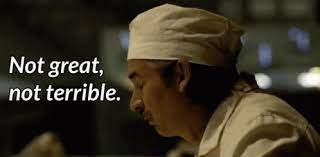

You can improve the results by tweaking the hyperparameters, but SORT has its limits.